In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Simple methods to classify the data --- 
from sklearn.preprocessing import StandardScaler # to rescale data 
from imblearn.over_sampling import RandomOverSampler # to equalized datasets
# from over_sampling import RandromOversampling
from sklearn.neighbors import KNeighborsClassifier # as we are classifying
from sklearn.metrics import classification_report # to check how good kNN behaved
from sklearn.naive_bayes import GaussianNB # minimize the probability of missclassification
from sklearn.linear_model import LogisticRegression # git sigmoid between two categories
from sklearn.svm import SVC # Support vector machine. (find hyperplance between categories)
# --------------------------------------------- 
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())


[]
False


Data is copied from https://archive.ics.uci.edu/ml/machine-learning-databases/magic/

In [6]:
cols = ["fLength","fWidth","fSize","fConc",
"fConc1","fAsym","fM3Long","fM3Trans","fAlpha","fDist","class"]
# the actual table does not have columns named, so we add them
df = pd.read_csv("magic04.data", names=cols)
df.head() # print the top of the data frame
df["class"].unique() # show unique values of the column 'clas'
df["class"] = (df["class"]=="g").astype(int)

### Classification problem 
Given a dataset with seveal features (columns), classify each row of data to one of the tow classes, e.g., pass features, predict the label.

#### Machine learning
ML is the study of algorithms that allows machine to learn from data. 
AI, ML, DS. 
- Supervised learnig: lable inputs usd. 
- Unsupervised learning: unlabled data to find patterns in data: cluster similar data; structure
- reinforsment learning: uses agent with rewards and penalties

#### Supervised learning
Consider a model; Given a feature vector that can consists of: 
- Data can be `nominal`, i.e., no hierachy. Use `one-hot encoding`. 
[1,0,0,0]
[0,1,0,0]
[0,0,1,0]
...
- Data can be `qualitative`, e.g., `ordinal data` with an order, from 1 to 10 or from sad to happy etc. 
- Data can be `quantitative`, ej, a number, int or double
All these features are used as an impot. 

Model predictions in Supervised Learning:
- `Classification`: assign a certain label/class ($\textit{multiclass}$ or $\textit{ binary classification}$)
- `Regression`: predict a $\textbf{continous}$ value. 

#### Model:
How to evaluate model/good or bad?
Consider a dataset. Meducal data where many phsyical attributes or a person are given and a task is to find out whether or not they have a diabities (0 or 1). All fieatures are qnatitative (numbers). Each row is the data for one person. Each columns is the feature. Feature vector.
Given a `feature matrix` X (columns of features), predict the `output for that feature vector` or the `target vector`.

Problem is represented as a linear algebra matrix equation: $X$...

But first, the data, the feature matrix has to be split into `training data` and `validation dataset` and `testing dataset`. 
Feed training one into the model. Asses what is the difference between training data and the output. This difference is the `loss`. Adjust the model. This constituttes `training`. Then put the validataion set into the model. This assures taht model can handle the new data. However, here loss is not put back into the model. 

#### Loss. 
The model with the smallest loss performs the best. 
Loss = prediciton - label. 
- L1 Loss $loss = \Sigma(|y_{real}-y_{pred})$ 
- L2 Loss $loss = \Sigma((y_{real}-y_{pred})^2)$ (less penalty for close reasult)
- Binary Cross-Entropy Loss (decreases with increasing performance)

#### Metrics of Performance
- Accuracy measured in percentage

In [7]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


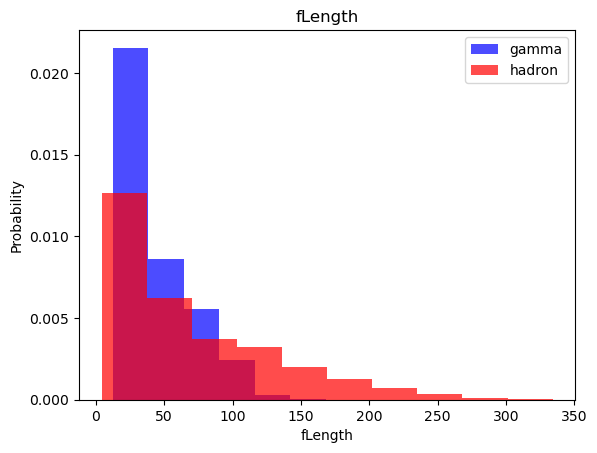

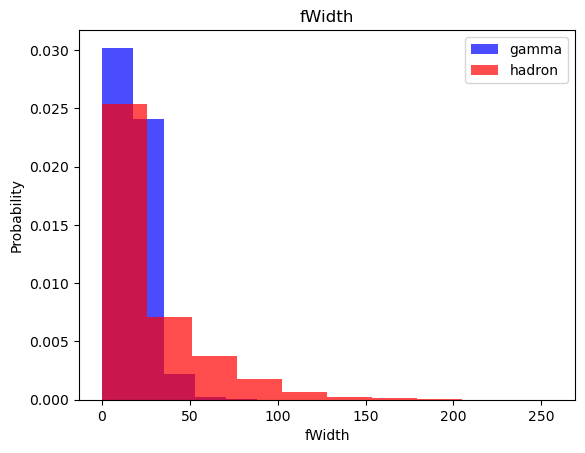

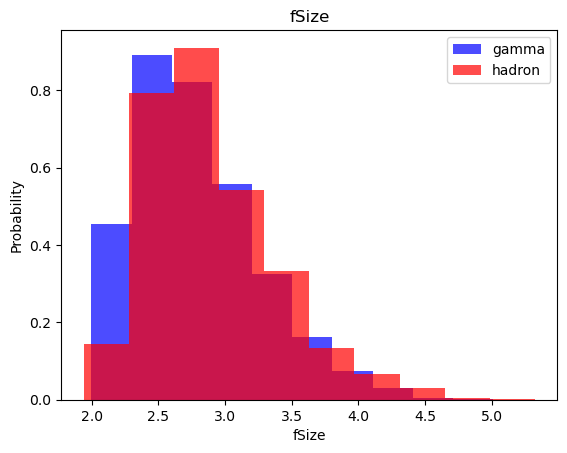

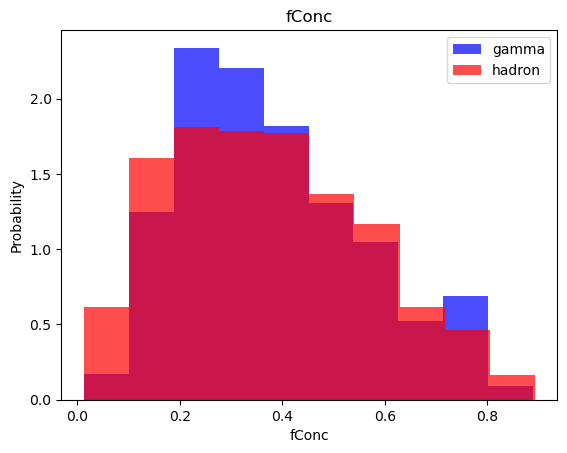

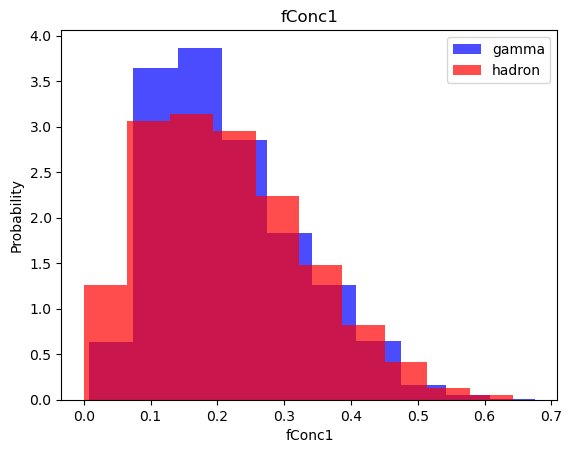

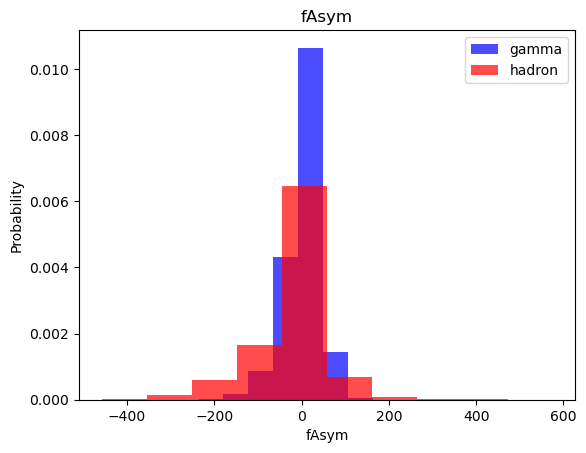

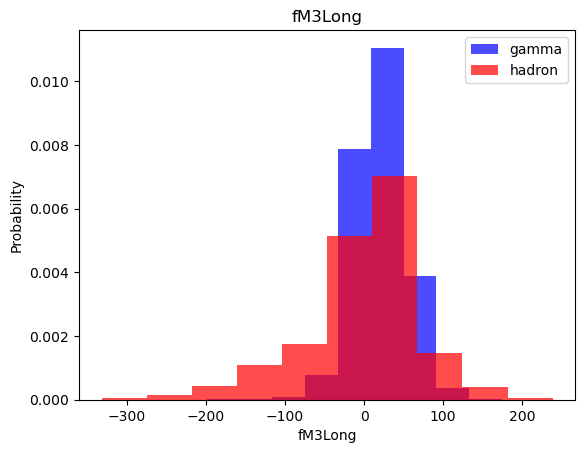

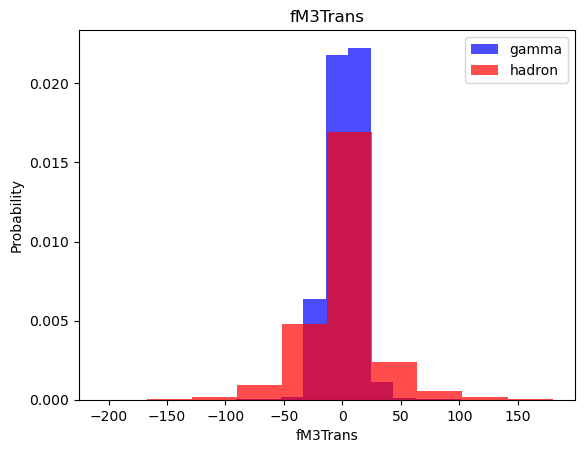

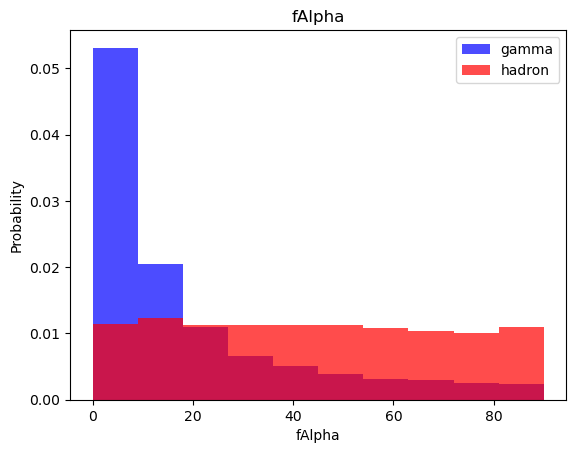

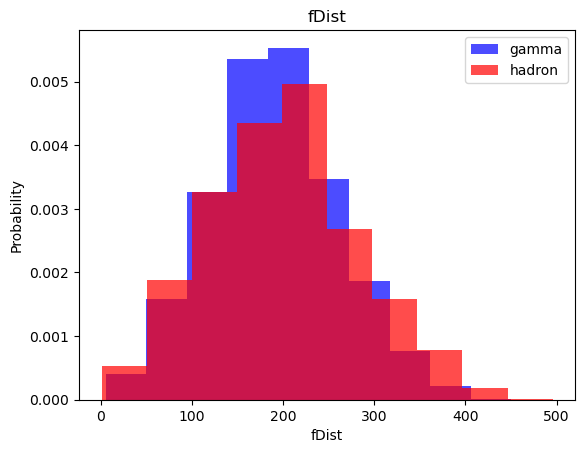

In [8]:
for label in cols[:-1]: # Data exploration :: Plot for each eature
    # here, density = True : normalize the distribution
    d1 = df[df["class"]==1][label]
    d0 = df[df["class"]==0][label]
    # Density=True aka noramlization by how many samples there are
    plt.hist(d1, color='blue', label='gamma', alpha=0.7, density=True)
    plt.hist(d0, color='red', label='hadron', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel("Probability") # As density = True !
    plt.xlabel(label)
    plt.legend()
    plt.show()


#### Data exploration result:
Diffirentating feature between 1 and 2 (hadrons and gammas) seems to be the fAlpha, which is evenly distributied for hadrons and skewed for gammas

In [9]:
# Split data into datasets
train, valid, test = np.split(df.sample(frac=1),[ int(0.6*len(df)), int(0.8*len(df)) ])
print(train.shape, ' ', df.sample(frac=1).shape)
print(valid.shape)
print(test.shape)

(11412, 11)   (19020, 11)
(3804, 11)
(3804, 11)


In [10]:
# Sacling the data so the different magnitudes of dofferent variables do not affect the result
def scale_dataset(dataframe : pd.DataFrame, oversample : bool=False):
    X = dataframe[dataframe.columns[:-1]].values # [[MAT]] as -1 is the result to be infereud
    Y = dataframe[dataframe.columns[-1]].values  # [VEC]
    # for fitting and stransforming the data:
    scaler = StandardScaler()
    X = scaler.fit_transform(X) # X -> new transformed object

    if (oversample):
        ros = RandomOverSampler() # generator for random oversampler
        X, Y = ros.fit_resample(X, Y) # take more from the lesser class and keep sampling from it

    # one 2d array for data; reshaping (1-,1) -> make 2D array with -1 -- using length of Y 
    data = np.hstack((X, np.reshape(Y, newshape=(-1, 1))))

    return (data, X, Y)

In [11]:
# Examine again the training dataset for the absence of biase
size_g = len(train[train["class"]==1]) # Gammas
size_h = len(train[train["class"]==0]) # gammas
print(f"TrainSet: g={size_g} h={size_h}")
# Size mismatch! The training will not be accurate. Oversampling is required.


TrainSet: g=7355 h=4057


In [12]:
# Oversampling the training dataset (increase number of hadrons)
train_scaled, X_train, y_train  = scale_dataset(dataframe=train, oversample=True)
size_g = np.sum(y_train==1) # Gammas
size_h = np.sum(y_train==0) # gammas
print(f"TrainSet: g={size_g} h={size_h}")
# Now both outcomes sets are equally sized

TrainSet: g=7355 h=7355


In [13]:
train_scaled, X_train, y_train  = scale_dataset(dataframe=train, oversample=True)
# validation and testing may not be evenly distributed; so oversample=False
train_valid, X_valid, y_valid  = scale_dataset(dataframe=valid, oversample=False)
train_test, X_test, y_test  = scale_dataset(dataframe=test, oversample=False)


#### KNN model (K-nearest neibours)
Get value from checking what is the value of $k$ the nearest neighbours 

Using Eucledian distance $d = \sqrt{(x_1- x_2)^2+(y_1-y_2)^2}$

$k\in(1-10)$ usually


In [14]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(repr(y_pred))
print(repr(y_test))

array([1, 1, 0, ..., 0, 1, 0])
array([0, 1, 0, ..., 0, 1, 0])


In [15]:
# using classification_report check how well predictions stuck up
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1283
           1       0.86      0.84      0.85      2521

    accuracy                           0.80      3804
   macro avg       0.78      0.79      0.78      3804
weighted avg       0.81      0.80      0.81      3804



- $\text{Precision} = \frac{\text{true positive}}{\text{false positive}}$ Out of labeled positive how many are really positive
- $\text{recall} = \frac{\text{true positive}}{\text{inferred positive}}$ out of trully positive how many are correctly inferred as positive

- Precision $n$ for $0$ is means that out of true labeled $0$ c $n$ percent are actually that class. 
- Recall - out of those that are actually that class how many do we get right $m$ percent

- f1 score for imbalanced dataset

$\textcolor{green}{\text{Overall, decent result for a very simple model}}$

#### Naive Base
- Conditional probability. $P(A|B)$ probability of $A$, geven $B$ 
E.g., example with a covid. $P(covid | positive)=P(covid+positive | positive)$ here $P(positive)$ is all people with positive (whether they have covid or not) 

Bayes rule:
$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$  
$B$ - given, fact. 

Bayes rule can be applied to classification
- Posteriour $P(C_k | x)$ probability of a category $k$; given feaute vector $x$ i.e., what is the probability that $x$ fit into $C_k$ category. 
- $P(C_k | x) = \frac{P(x|C_k)\times P(C_k)}{P(x)}$, here $P(C_k | x)$ is the posteriour; $P(x|C_k)$ is the likelihood (probability to see featres $x$ from $C_k$); $P(C_k)$ is the prioir; $P(x)$ is the evidence

Rule for naive base:

\begin{equation}
    P(C_{k}| x_1...x_n) \propto p(C_k)\Pi_{i=1}^n p(x_i|C_k)
\end{equation}

$x_1...x_k$ are the features. $C_k$ here is the constant (that is why it is out of the bracket)

\begin{equation}
    P(C_k,x_1,...x_n) \propto P(x_1...x_k)P(C_k)
\end{equation}

Propto sign here is because we do not care about denominator. 
Next, naive Bayes assumes that $x_i...x_n$ are independent

\begin{equation}
    P(x_1...x_n|C_k) = P(x_1|C_k)...P(x_n|C_k) = \Pi_{i=1}^n P(x_i|C_k)
\end{equation}

Probability of this feature vector ro be in this class is proportional to the propability of the class itself times the probability of each featue to be a part of that class

#### Application :: MAP :: Maximum A Posteriori
Minimize the probability of miss-classification
Find $texttt{argmax}$ that maximasizes $P(C_k|x_1...x_n)$
$\hat{y} = \texttt{argmax}_{k\in(1,k)} P(C_k|x_1...x_n)$

In [16]:
# Using naive base
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train,y_train)
y_pred = nb_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.42      0.51      1283
           1       0.75      0.89      0.81      2521

    accuracy                           0.73      3804
   macro avg       0.70      0.65      0.66      3804
weighted avg       0.72      0.73      0.71      3804



The result is worse than what was with the NN method. Accuracy is lower

#### Logistic Regression

Estimate probability (taht it is class 0 or 1) Then $y=kx+b$ is replaced by $p=mx+b$. Probability is normalized to 1, so consider $p/(1-p)\in(-\infty,+\infty)$. This is called `odds`. Then consider 

$\ln(p/(1-b)) = mx + b$

We can solve it $p = 1 / (1+\exp^{-mx+b})$. This is `sigmoid function`. $S(x)=1/(1+e^{-x})$. 

This curve can fit better two categories that switch from one to anouther. This is `logistic legression`, -- fitting the data with sigmoid. 

It is `simple` regression if the variable is one. If many features are considered, it is `multiple logistic regression`.

In [17]:
# Using logistic regression
lg_model = LogisticRegression()# many parameters can be used for twicking
lg_model = lg_model.fit(X_train, y_train)
lg_pred = lg_model.predict(X_test)
print(classification_report(y_test, lg_pred))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69      1283
           1       0.85      0.81      0.83      2521

    accuracy                           0.78      3804
   macro avg       0.76      0.77      0.76      3804
weighted avg       0.79      0.78      0.78      3804



#### Support Vector Machines (SVM)

Find a lane or a surface that devides the data into classes the best. $\textit{Best data divider}$. Use `margin` to determine the best one. All points should be as far from this surface as possible. We need the surface that maximises the margines. The surface is determined with the support vectors, -- vectors from the data points to the surface. 

The model is very susseptible to outliers. 

In order to simplify the finding of the hyperplane, `kernel tricks` are used $x\rightarrow(x,x^2)$, where we applied a square kernel

In [18]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)
svm_predi = svm_model.predict(X_test)
print(classification_report(y_test,svm_predi))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1283
           1       0.90      0.89      0.90      2521

    accuracy                           0.86      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



This method took longer but gave a better result. I.e., the applaying model to the test set led to a more accurate classification. 
All the aforementioned method gave only about 70-80% accuracy with SVM being the best. 

# Neural Networks

Input layers $\rightarrow$ hidden layers $\rightarrow$ output layers. 

Layers are comprised of neurons. Each neuron is one feature. One value $x_i$

Each neuron has a weight applied to it $w_i$ i.e., ($x_i w_i$)

Then outcome is summed $\Sigma(x_i w_i)$ and it is fed into another neuron. 

Before a bias is added as $\Sigma(x_i w_i) \times b_i$ 

This goes into activation function, then to output

Neuran Net without an activation function is just a linear model

Activation functions are not linear (it must not be linear)
- Sigmoid
- tanh
- Relu

Use loss to imrove the output

Loss function 
- L2 (quadratic)

`Gradient descend` is used to improve the output (decrease the loss). Follow down the bell of the L2 loss function. Backstepping is determined by `backpropagation` via weight update: $w_{i;\,new} = w_{i;\,old}+\alpha$. $\alpha$ is the learning rate. This controls how long does the neural net takes to converge. 


In the example below the `macroparameters` are fixed, but they can be tuned to achieve better performance/accuracy of the model. 
Finding optimal ones is called `grid search`. One can go through a grid of 
- N nodes in different layers
- learning rate
- batch size
- ...

In [19]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu',input_shape=(10,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
# project the result to either 0 or 1 with the sigmoid function
nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="binary_crossentropy",metrics=['accuracy'])


2023-02-16 10:29:19.020023: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
# plotting from Tensforflow info page
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='accuracy')
    plt.plot(history.history['val_accuracy'],label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary crossentropy')
    plt.grid(True)
    plt.legend()
    plt.show()


In [21]:
# leave a validation split for checking how well the data perform (20\%)
#history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
#print("Done")

In [22]:
#plot_accuracy(history)
#plot_loss(history)

Good: we find steadely decreasing loss; increasing accuracy and validation accuracy. 
It is expected that the validation loss and accuracy are worse than the training loss and accuracy. As the validation is the new data. 

In [32]:
def plot_model(history):
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1,figsize=(10,4))
    ax1.plot(history.history['accuracy'],label='accuracy')
    ax1.plot(history.history['val_accuracy'],label='val_accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history.history['loss'],label='loss')
    ax2.plot(history.history['val_loss'],label='val_loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Binary crossentropy')
    ax2.grid(True)
    ax2.legend()

    plt.show()

def train_model(X_train, y_train, n_nodes, prob_drop, lr, batch_size, epochs):
    print(f"Running N={n_nodes} p_drop={prob_drop} lr={lr} batch={batch_size} ep={epochs}")
    nn_model2 = tf.keras.Sequential([
        tf.keras.layers.Dense(n_nodes, activation='relu',input_shape=(10,)),
        tf.keras.layers.Dropout(prob_drop), # randomly chose a node and don't train them (prevents overfitting)
        tf.keras.layers.Dense(n_nodes, activation='relu'),
        tf.keras.layers.Dropout(prob_drop), # randomly chose a node and don't train them (prevents overfitting)
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    # project the result to either 0 or 1 with the sigmoid function
    nn_model2.compile(optimizer=tf.keras.optimizers.Adam(lr), 
        loss="binary_crossentropy",metrics=['accuracy'])
    # train the model 
    history = nn_model2.fit(X_train, y_train, 
        epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    return (nn_model2, history)

In [ ]:
# settings
epochs = 100
num_nodes = [16, 32, 64]
p_drops = [0, 0.2]
lrs = [0.1, 0.005, 0.001]
batch_sizes = [32, 64, 128]

least_val_loss = float('inf')
least_loss_model = None

for n_node in num_nodes:
    for p_drop in p_drops:
        for lr in lrs:
            for batch_size in batch_sizes:
                # train model with new NN settings
                i_model, i_history = train_model(X_train=X_train, y_train=y_train,
                    n_nodes=n_node, prob_drop=p_drop,lr=lr,batch_size=batch_size, epochs=epochs)
                # plot the model performance
                plot_model(i_history)
                # check how the model performs on a validation set
                val_loss, val_metrics = i_model.evaluate(X_valid, y_valid)
                print(f"\t val_loss{val_loss}")
                if (float(val_loss) < least_val_loss):
                    least_val_loss = float(val_loss)
                    least_loss_model = i_model
                    
                    


In [34]:
print(least_val_loss)

0.6962395906448364


The best model is determined by the largest accuracy and lowest lass. 
We find largest accuracy accuracy of 0.87. 
Validation loss must decrease with epoch 
Accruacy must increase with epoch. 
Now, cons

In [36]:
nn1_y_predict = least_loss_model.predict(X_test)
nn1_y_predict = (nn1_y_predict > 0.5).astype(int)
print(nn1_y_predict)

119/119 [==============================] - 0s 4ms/step


Here we find values that are either too close to zero or to 1. This is due to `sigmoid` output layer. Remember that we were looking at two categories $0$ and $1$. Cast the outcome as 0,1